<a href="https://colab.research.google.com/github/FYLSunghwan/mobile-serving-tutorials/blob/main/DevSeminar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building Basic Models

PyTorch, 또는 TensorFlow는 복잡한 연산을 수행하도록 도와주는 Framework입니다. Python을 통해 연산 그래프를 정의한 뒤, 해당 연산 그래프, 다른 말로 모델을 CPU, GPU, 또는 TPU와 같은 다른 특수한 프로세서에서 가속받을 수 있도록 도와줍니다.

## Building Model with simple Adder and Multiplier

PyTorch의 모델은 `nn.Module`을 상속하는 Class를 만들어서 생성할 수 있습니다. `nn.Module` Class는 `__init__()`과 `forward()`함수가 있습니다. `__init__()`, 즉 생성자에서는 모델이 생성되었을 때 모델의 연산에 필요한 연산자들(모듈)을 정의합니다. `forward()`에서는 Model이 불렸을 때의 연산 그래프를 정의합니다.

PyTorch의 모델은 Nested Model을 지원합니다. 이 말은, 복잡한 모델도 간단한 모델을 Component로 만들어서 모델을 Abstraction한 후, 이를 Primitive로 새로운 모델을 구성할 수 있음을 의미합니다. 전자공학부의 회로설계처럼 간단한 논리 Gate들을 통해 복잡한 회로를 구성한 뒤, 이를 다른 회로의 부품으로 사용하는 원리와 비슷합니다.

자, 그러면 직접 코드를 통해서 모델을 구현해보겠습니다.

### 필요한 라이브러리 import

In [2]:
import torch
import torch.nn as nn

### 연산 정의

다음과 같은 연산을 정의해보겠습니다.
$$(5x + 3) \times (2x - 10)$$

In [3]:
class SimpleAdderMult(nn.Module):
  
  # 아래 코드는 생성자로, 모델이 생성되었을 때의 연산자들을 정의하게 됩니다.
  # 지금 모델에서는 따로 Nested Model로 다른 연산자를 불러오는 것이 아니기때문에 아무 내용도 적지 않겠습니다.
  def __init__(self):
    super().__init__()

  # 아래 코드는 forward함수로, 연산그래프를 정의하게 됩니다.
  # 우선은 앞서 정의했던 연산식을 구현해보도록 하겠습니다.
  def forward(self, x):
    lhs = 5 * x + 3
    rhs = 2 * x - 10

    return lhs * rhs

### Model Inference

이제, 방금 만들었던 모델을 가지고 추론을 진행해보겠습니다. 모델은 파이썬의 클래스처럼 인스턴스를 만들어주시면 되고, Inference를 할때는 그 모델에 대해서 Function Call을 진행해주시면 됩니다. 모델에 값을 넘길때는 간단한 Scalar값을 넘길수도 있고, torch에서 정의된 Tensor의 형태로 전달할 수 있습니다. Tensor는 Multi-Dimensional Array라고 생각해주시면 될 것 같습니다. (1차원 Tensor는 Vector, 2차원 Tensor는 Matrix, 등등..)

In [4]:
model = SimpleAdderMult()
print(model(3))
print(model(torch.Tensor([3, 4, 5])))

-72
tensor([-72., -46.,   0.])


### Model Save and Load

모델을 만들었으면, 저장하고 불러올 수 있어야 합니다. torch에서는 모델을 저장하고 불러올 수 있는 API를 제공합니다.

In [5]:
torch.save(model, "model.pt")
loaded_model = torch.load("model.pt")

In [6]:
loaded_model(3)

-72

In [7]:
import torch.utils.mobile_optimizer as mobile_optimizer

scripted_model = torch.jit.script(model)
opt_model = mobile_optimizer.optimize_for_mobile(scripted_model)
opt_model.save("torch_model.pt")
print('done')

done


## Building Model with Trainable Variables

지금까지 PyTorch의 모델을 간단한 연산그래프를 통해서 만들어보았습니다. 하지만, 딥러닝이 유용한 이유는 이렇게 만든 모델이 Fixed Parameter가 아니라, Trainable Parameter를 통해서 실제 데이터를 학습할 수 있기 때문입니다.

### Making Trainable Variables

In [8]:
class TrainableModel(nn.Module):
  
  # torch.Tensor를 통해 Trainable Tensor를 만들어보겠습니다.
  def __init__(self):
    super().__init__()
    self.w = nn.Parameter(torch.zeros(1))
    self.b = nn.Parameter(torch.zeros(1))

  # y = wx + b라는 모델을 만들어보겠습니다.
  # w와 b는 Trainable Parameter가 됩니다.
  def forward(self, x):
    return self.w * x + self.b

In [9]:
model = TrainableModel()
model(10)

tensor([0.], grad_fn=<AddBackward0>)

### Train Model

방금 만들었던 모델을 직접 학습시켜보겠습니다.  
Watch a model Train:  
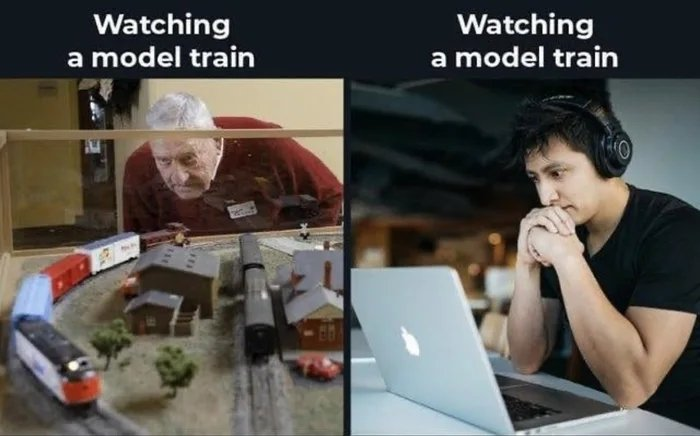

In [10]:
# 모델을 정의합니다.
model = TrainableModel()

# 어떤 알고리즘으로 Model Parameter를 Optimize시킬건지를 결정하게 됩니다.
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)

# Loss Function으로 Model의 학습 방향을 결정하게 됩니다.
criterion = nn.MSELoss()

# 3x + 5를 학습해보겠습니다.
X = torch.Tensor([[0], [1], [2]])
Y = torch.Tensor([[5], [8], [11]])

epochs = 10000
losses = []
for i in range(epochs):
  # Optimizer를 초기화시킵니다.
  # Pytorch에서 AutoGrad는 Gradient를 계속 저장하게 되는데, 이를 비워주어야 합니다.
  optimizer.zero_grad()

  # 모델을 가지고 값을 추론합니다.
  y_inferenced = model(X)

  # Loss Function을 통해 실제 값과 얼마나 차이가 있는지 계산합니다.
  loss = criterion(y_inferenced, Y)

  # Back Propagation
  loss.backward()

  # Optimizer를 동작시켜 Model의 Parameter를 업데이트합니다.
  optimizer.step()

  if i%100 == 0:
    print("Epoch {} : Loss {}".format(i, loss.item()))
  losses.append(loss.item())

Epoch 0 : Loss 70.0
Epoch 100 : Loss 27.631338119506836
Epoch 200 : Loss 11.284296989440918
Epoch 300 : Loss 4.936543941497803
Epoch 400 : Loss 2.435511350631714
Epoch 500 : Loss 1.418150544166565
Epoch 600 : Loss 0.9764759540557861
Epoch 700 : Loss 0.7612321972846985
Epoch 800 : Loss 0.6377518177032471
Epoch 900 : Loss 0.5538214445114136
Epoch 1000 : Loss 0.4889357388019562
Epoch 1100 : Loss 0.43481507897377014
Epoch 1200 : Loss 0.3879149258136749
Epoch 1300 : Loss 0.34654977917671204
Epoch 1400 : Loss 0.30977746844291687
Epoch 1500 : Loss 0.2769773602485657
Epoch 1600 : Loss 0.24767720699310303
Epoch 1700 : Loss 0.2214869260787964
Epoch 1800 : Loss 0.19806896150112152
Epoch 1900 : Loss 0.17712964117527008
Epoch 2000 : Loss 0.15840454399585724
Epoch 2100 : Loss 0.14165915548801422
Epoch 2200 : Loss 0.1266840100288391
Epoch 2300 : Loss 0.11329200863838196
Epoch 2400 : Loss 0.10131528973579407
Epoch 2500 : Loss 0.0906049981713295
Epoch 2600 : Loss 0.08102700859308243
Epoch 2700 : Loss 0

### Model Inference

In [11]:
model(3)
# 3 * 3 + 5

tensor([14.0082], grad_fn=<AddBackward0>)

### Model Train Result Graph (Loss Graph)

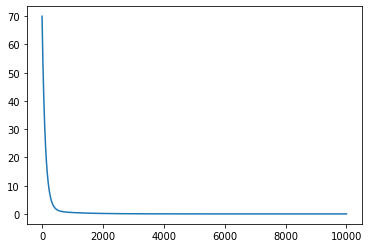

In [12]:
import matplotlib.pyplot as plt

plt.plot(losses)

### Save Model

In [13]:
torch.save(model, "simple_model.pt")
import torch.utils.mobile_optimizer as mobile_optimizer

scripted_model = torch.jit.script(model)
opt_model = mobile_optimizer.optimize_for_mobile(scripted_model)
opt_model.save("torch_model.pt")
print('done')

done


# Convert Model to ONNX and TensorFlow Lite

이렇게 만들어진 Python모델은 Python을 지원하는 PC라면 어디에서든 Inference를 진행할 수 있습니다. 하지만, 오늘 하고자하는 것은 다양한 플랫폼에서 동작할 수 있는 Inference 코드를 작성하는 것입니다. 이를 위해서 C++ API를 사용하게 되는데, Pytorch말고 연산량에 대해 더욱 최적화가 잘 되어있는 TensorFlow Lite로의 변환을 진행해보려 합니다.

### Convert to ONNX

In [14]:
# 모델 변환
model = torch.load("simple_model.pt")
input_tensor = torch.Tensor([0])

torch.onnx.export(model,                     # 실행될 모델
                  input_tensor,                 # 모델 입력값 (튜플 또는 여러 입력값들도 가능)
                  "simple_model.onnx",         # 모델 저장 경로 (파일 또는 파일과 유사한 객체 모두 가능)
                  export_params=True,        # 모델 파일 안에 학습된 모델 가중치를 저장할지의 여부
                  opset_version=10,          # 모델을 변환할 때 사용할 ONNX 버전
                  do_constant_folding=True,  # 최적하시 상수폴딩을 사용할지의 여부
                  input_names = ['input'],   # 모델의 입력값을 가리키는 이름
                  output_names = ['output']) # 모델의 출력값을 가리키는 이름

### Convert to TensorFlow

In [15]:
!pip install onnx_tf

     |████████████████████████████████| 225kB 34.3MB/s 
     |████████████████████████████████| 12.2MB 221kB/s 
     |████████████████████████████████| 686kB 47.2MB/s 


In [16]:
import onnx
from onnx_tf.backend import prepare

onnx_model = onnx.load("simple_model.onnx")
onnx.checker.check_model(onnx_model)

tf_rep = prepare(onnx_model)
tf_rep.export_graph("simple_model")

INFO:tensorflow:Assets written to: simple_model/assets


INFO:tensorflow:Assets written to: simple_model/assets


### Convert to TensorFlow Lite for Mobile Inference

In [17]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_saved_model("simple_model")
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

In [18]:
with open('simple_model.tflite', 'wb') as f:
    f.write(tflite_model)

## Rewrite Model Code to TF and Weight Conversion

TensorFlow 코드를 직접 작성 후, 모델을 옮겨보겠습니다.

### Write PyTorch Code and Train

In [19]:
class TorchModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc = nn.Linear(1, 1)

  def forward(self, x):
    return self.fc(x)

In [29]:
# 모델을 정의합니다.
model_torch = TorchModel()

# 어떤 알고리즘으로 Model Parameter를 Optimize시킬건지를 결정하게 됩니다.
optimizer = torch.optim.SGD(model_torch.parameters(), lr = 0.001)

# Loss Function으로 Model의 학습 방향을 결정하게 됩니다.
criterion = nn.MSELoss()

# 3x + 5를 학습해보겠습니다.
X = torch.Tensor([[0], [1], [2]])
Y = torch.Tensor([[5], [8], [11]])

epochs = 10000
losses = []
for i in range(epochs):
  # Optimizer를 초기화시킵니다.
  # Pytorch에서 AutoGrad는 Gradient를 계속 저장하게 되는데, 이를 비워주어야 합니다.
  optimizer.zero_grad()

  # 모델을 가지고 값을 추론합니다.
  y_inferenced = model_torch(X)

  # Loss Function을 통해 실제 값과 얼마나 차이가 있는지 계산합니다.
  loss = criterion(y_inferenced, Y)

  # Back Propagation
  loss.backward()

  # Optimizer를 동작시켜 Model의 Parameter를 업데이트합니다.
  optimizer.step()

  if i%100 == 0:
    print("Epoch {} : Loss {}".format(i, loss.item()))
  losses.append(loss.item())

Epoch 0 : Loss 47.04220962524414
Epoch 100 : Loss 18.51696014404297
Epoch 200 : Loss 7.5167083740234375
Epoch 300 : Loss 3.250178337097168
Epoch 400 : Loss 1.5735658407211304
Epoch 500 : Loss 0.895414412021637
Epoch 600 : Loss 0.6042520403862
Epoch 700 : Loss 0.46492770314216614
Epoch 800 : Loss 0.38680991530418396
Epoch 900 : Loss 0.3347970247268677
Epoch 1000 : Loss 0.29513418674468994
Epoch 1100 : Loss 0.26229581236839294
Epoch 1200 : Loss 0.23393933475017548
Epoch 1300 : Loss 0.20896704494953156
Epoch 1400 : Loss 0.18678320944309235
Epoch 1500 : Loss 0.1670026332139969
Epoch 1600 : Loss 0.14933519065380096
Epoch 1700 : Loss 0.13354317843914032
Epoch 1800 : Loss 0.11942420154809952
Epoch 1900 : Loss 0.10679855197668076
Epoch 2000 : Loss 0.09550865739583969
Epoch 2100 : Loss 0.08541225641965866
Epoch 2200 : Loss 0.07638320326805115
Epoch 2300 : Loss 0.068308524787426
Epoch 2400 : Loss 0.06108756363391876
Epoch 2500 : Loss 0.054630011320114136
Epoch 2600 : Loss 0.04885518550872803
Epo

In [30]:
model_torch(torch.Tensor([3]))
# 3 * 3 + 5

tensor([14.0063], grad_fn=<AddBackward0>)

### Rewrite TensorFlow Code

PyTorch로 구현한 코드는 다음과 같습니다.

```python
class TorchModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc = nn.Linear(1, 1)

  def forward(self, x):
    return self.fc(x)
```

In [26]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

In [49]:
class Model_tf(Model):
  def __init__(self):
    super().__init__()
    self.fc = Dense(1)

  def call(self, x):
    return self.fc(x)

model_tf = Model_tf()
model_tf(tf.zeros([1,1]))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.]], dtype=float32)>

### Weight Transfer

PyTorch Weight and Bias

In [50]:
model_torch.fc.weight

Parameter containing:
tensor([[3.0039]], requires_grad=True)

In [51]:
model_torch.fc.bias

Parameter containing:
tensor([4.9945], requires_grad=True)

TensorFlow Kernel(Weight) and Bias

In [52]:
model_tf.fc.kernel

<tf.Variable 'model_tf_2/dense_2/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-0.3243804]], dtype=float32)>

In [53]:
model_tf.fc.bias

<tf.Variable 'model_tf_2/dense_2/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>

Weight Transfer

In [54]:
model_tf.fc.kernel.assign(model_torch.fc.weight.detach().numpy().T)

<tf.Variable 'UnreadVariable' shape=(1, 1) dtype=float32, numpy=array([[3.0039303]], dtype=float32)>

In [55]:
model_tf.fc.bias.assign(model_torch.fc.bias.detach().numpy())

<tf.Variable 'UnreadVariable' shape=(1,) dtype=float32, numpy=array([4.9945493], dtype=float32)>

Inference

In [60]:
model_torch(torch.Tensor([[3]]))

tensor([[14.0063]], grad_fn=<AddmmBackward>)

In [61]:
model_tf(tf.constant([[3]]))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[14.00634]], dtype=float32)>